In [1]:
import pyro
import torch
import pyro.distributions as pdist
import torch.distributions as dist
from torch.distributions import constraints


In [2]:
import matplotlib.pyplot as plt

##### Original model:

$P(z_{t+1}|z_{t})=Normal[a z_{t}+b, 0.1](z_{t+1})$

In [15]:
a = 0.2
b = 1

def model1(z0, T_seq, T_bseq, K):
    '''
    - ``t_seq`` -- general sequence length
    i.e. global time
    
    - ``T_bseq`` -- length of sequence in each batch
    (must divide `t_seq`) i.e. local time
    
    - ``K`` -- count of sequences in each batch
    
    Return:
    containing batchs tensor of shape:
    T_seq/T_bseq, T_bseq, K
    '''
    z_prev = z0 * torch.ones(K)
    
    x_batch = torch.tensor([])
    z_batch = torch.tensor([])
    
    for i in range(int(T_seq/T_bseq)):
        zs = torch.tensor([])
        xs = torch.tensor([])
        with pyro.plate("plate0", K):
            for t in range(T_bseq):
                # j = K - i % K
                # z.shape == K
                z = pyro.sample("z_%d" % t,
                                pdist.Normal(a*z_prev+b, 0.1*torch.ones(1)))
                               
                z_prev = z
                x = pyro.sample("x_%d" % t,
                                pdist.Bernoulli(torch.sigmoid(z)))
                # zs.shape will be (after for loop) (K, T_bseq)
                zs = torch.cat([zs,
                                torch.unsqueeze(z, 0)], 0)
                xs = torch.cat([xs,
                                torch.unsqueeze(x, 0)], 0)
        
        # z_batch.shape will be (after for loop) (T_seq/T_bseq, )       
        x_batch = torch.cat([x_batch, torch.unsqueeze(xs.T, 0)], 0)
        z_batch = torch.cat([z_batch, torch.unsqueeze(zs.T, 0)], 0)
    
    print("\nz.shape:")
    print(z.shape)
    print("\nzs.shape:")
    print(zs.shape)
    print("\nz_batch.shape:")
    print(z_batch.shape) 
    return(x_batch, z_batch)

In [11]:
300*60

18000

In [13]:
# xs, zs = model1(1.0, 18, 6, 2)

In [14]:
xs, zs = model1(1.0, 18000, 60, 20)


z.shape:
torch.Size([20])
zs.shape:
torch.Size([60, 20])
z_batch.shape:
torch.Size([300, 20, 60])
torch.Size([300, 20, 60])
torch.Size([300, 20, 60])


In [20]:
print(torch.flatten(zs, 1).shape)
print(torch.flatten(xs[:, -1, :], 0).shape)

torch.Size([300, 1200])
torch.Size([18000])


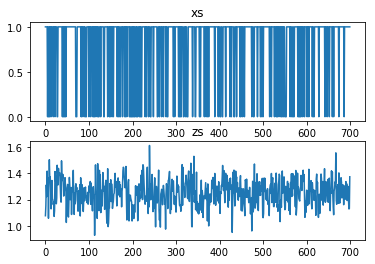

In [18]:
fig, axs = plt.subplots(2, 1)

# plot last (from K=20) global sequence:
# only 700 of them for convenience:
axs.flat[0].plot(torch.flatten(xs[:, -1, :], 0)[:700])
axs.flat[0].set_title("xs")
axs.flat[1].plot(torch.flatten(zs[:, -1, :], 0)[:700])
axs.flat[1].set_title("zs")

plt.show()

##### Condition:

In [40]:
def cond_model1(xs_batch):
    '''Condition x on observed data (xs_batch) 
    - ``xs_batch`` -- shape must looks like:
    (seqs, time)
    
    Because of usage of plate all seqs[t] will be sampled
    at once (for fixed t).
    _
    x.shape == z0.shape == Size([K])
    where K is count of seqs in batch (xs_batch.shape[0])
    '''
    T = xs_batch.shape[1]
    z0 = xs_batch[:,0]
    # print(z0.shape)
    z_prev = z0
    with pyro.plate("plate1", xs_batch.shape[0]):
        
        # for i in range(T):
        #     j = K - i % K
        for t in range(1, T):
        
            # this will be taken from guide
            # so we don't care about it here:
            z = pyro.sample("z_%d" % t,
                            pdist.Normal(z_prev, torch.tensor([0.1])))
            z_prev = z
            # print(xs_batch[:,t].shape)
            
            # x.shape == z0.shape == Size([K])
            # where K is count of seqs in batch:
            x = pyro.sample("x_%d" % t,
                            pdist.Bernoulli(torch.sigmoid(z)),
                            obs=xs_batch[:, t])
            

In [41]:
cond_model1(xs[0])
# xs[0][:,0].shape
# xs[0][0].shape

##### Guide:

In [67]:
def guide1(xs_batch):
    '''We try to approximate a*z+b with
    a \in [0.1, 10], b \in [0.1, 10]'''
    
    T = xs_batch.shape[1]
    K = xs_batch.shape[0]
    z0 = xs_batch[:, 0]
    
    z_prev = z0
    a = pyro.param("a", torch.tensor(1.0),
                   constraint=constraints.interval(0.1, 10))
    b = pyro.param("b", torch.tensor(1.0),
                   constraint=constraints.interval(0.1, 10))
    
    # for i in range(T):
    #     j = K - i % K
    with pyro.plate("plate1", K):
        for t in range(1, T):
            # this value will be used for cond_model also
            z = pyro.sample("z_%d" % t,
                            pdist.Normal(a*z_prev+b, torch.tensor([0.1])))
            z_prev = z


In [43]:
guide1(xs[0])

##### Learning

In [68]:
LEARNING_RATE = 1.0e-7

# setup the optimizer:
adam_params = {"lr": 0.05, "betas": (0.9, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

# adam_params = {"lr": 0.00000000000005, "betas": (0.998, 0.999)}
# optimizer = pyro.optim.Adam(adam_args)

# adam_args = {"lr": LEARNING_RATE}
# optimizer = pyro.optim.Adam(adam_args)
# optimizer = pyro.optim.Adam({"lr": 0.00000000001, "betas": (0.95, 0.999)})
# optimizer=pyro.optim.SGD({"lr": 0.01,
#                         "momentum":0.9})

# setup the loss:
# loss = pyro.infer.CSIS()
# loss = pyro.infer.TraceEnum_ELBO()
loss = pyro.infer.Trace_ELBO()
# optimizer.zero_grad()
pyro.clear_param_store()


svi = pyro.infer.SVI(model=cond_model1,
                     guide=guide1,
                     # guide=coin_parametrized_guide,
                     optim=optimizer,
                     loss=loss)


losses, as1, bs1  = [], [], []
# num_steps = 37  # 2500

for idx, x in enumerate(xs):
    # import pdb; pdb.set_trace()
    losses.append(svi.step(x))
    as1.append(pyro.param("a").item())
    bs1.append(pyro.param("b").item())
    # print(pyro.param("a").grad)
    # cont = msg["continuation"]

##### Results:

In [69]:
as1[-1]

0.7255560755729675

In [70]:
bs1[-1]

0.35470592975616455

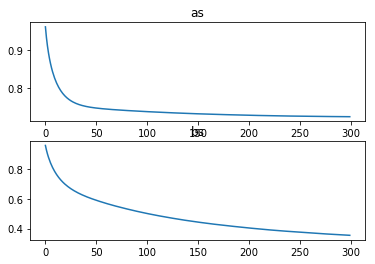

In [71]:
fig, axs = plt.subplots(2, 1)

axs.flat[0].plot(as1)
axs.flat[0].set_title("as")
axs.flat[1].plot(bs1)
axs.flat[1].set_title("bs")

plt.show()

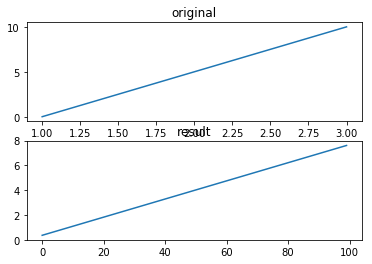

In [72]:
x = torch.linspace(0, 10, 100)
fig, axs = plt.subplots(2, 1)

axs.flat[0].plot(a*x+b, x)
axs.flat[0].set_title("original")
axs.flat[1].plot(as1[-1]*x+bs1[-1])
axs.flat[1].set_title("result")

plt.show()
